In [32]:
from functools import partial
import equinox as eqx
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
import optax
from scipy.interpolate import griddata
from tqdm import tqdm

print(jax.devices())
jax.config.update("jax_enable_x64", True)

[CudaDevice(id=0)]


## Problem steup
### PDE solution operator
We consider a parametric PDEs of the form:
$$\mathcal{N}(u,s)=0$$
where $u$ is the input function and $s$ is the unknown PDE's solution function. 

Our PDE solution operator would be:
$$\mathcal{G}(u) \mapsto s$$
### Burgers equation
$$\frac{\partial s}{\partial t} + s\frac{\partial s}{\partial x} = \kappa \frac{\partial^2 s}{\partial x^2} \quad \text{with} \quad (x,t) \in [-\rho \pi,\rho \pi] \times [0,T], \kappa > 0$$
with periodic boundary
$$ s(x-\pi,t)=s(x+\pi,t), \quad  s(x,0)=u(x) $$
where $\kappa$ denotes the fuild viscosity, $u(x)$ is $2\pi$-preiodic woth zero mean $\int_{-\pi}^\pi u(t)dt=0$ and $\rho,T \in \mathbb{R}$

Hence, $\mathcal{G}$ for above map the initial condition $u(x)$ to the solution to Burgers equation $s(x,t)$.

We will approximate the implicit solution operator ($\mathcal{G}$) with a DeepONet ($\tilde{\mathcal{G}}$), which is a map as follows:
$$\mathbb{R}^m \times \mathbb{R}^2 \rightarrow \mathbb{R}$$
$$(\vec{v},\vec{y}) \mapsto \tilde{\mathcal{G}}(\vec{v},\vec{y}) := \sum_{k=1}^q \mathcal{N}_{\text{B,k}}(\vec{v}) \cdot \mathcal{N}_{\text{T,k}}(\vec{y})$$
where $\mathcal{N}_{\text{B}}$ and $\mathcal{N}_{\text{T}}$ are two neural networks mapping $\mathbb{R}^m \rightarrow \mathbb{R}^q$ and $\mathbb{R}^2 \rightarrow \mathbb{R}^q$ respectively. $q$ is the common output dimension of the branch and the trunk net, which is a hyperparameter to be chosen.
### Training loss
$$\mathcal{L}_{\text{Training}}(\theta) = \frac{1}{\text{N}_\text{training}\text{P}_\text{training}}\sum_{i=1}^{\text{N}_\text{training}}\sum_{j=1}^{\text{P}_\text{training}} \left|s_i(x_{ij},t_{ij})-\sum_{k=1}^q\mathcal{N}_{\text{B,k}}(u_i(x_1),\cdots,u_i(x_m)) \cdot \mathcal{N}_{\text{T,k}}(x_{ij},t_{ij}) \right|^2$$

Therefore, we have 3 class of training points:
- $u_{\text{training}} \in \mathbb{R}^{N_{\text{training}} \times m}$: evalutions of the input functions at the $m$ sensors, i.e. 
$$\boldsymbol{u}_i(x) = [\boldsymbol{u}_i(x_1),\cdots,\boldsymbol{u}_i(x_m)] \quad \forall i \in \{1,\cdots,N_{\text{training}}\}$$
- $y_{\text{training}} \in \mathbb{R}^{N_{\text{training}} \times P_{\text{training}} \times 2}$: a set of uniformly sampled collocation points for each input (query points), i.e.
$$(x_{ij},t_{ij}) \sim \mathcal{U}(([\rho \pi, \rho \pi] \times [0,T])^{P_{\text{training}}}) \quad \forall i \in \{1,\cdots,N_{\text{training}}  \}$$
- $s_{\text{training}} \in \mathbb{R}^{N_{\text{training}} \times P_{\text{training}}}$: numberical solution of PDE at query points, i.e.
$$s_i(x_{ij},t_{ij}) \quad \forall i \in \{ 1,\cdots,N_{\text{training}} \}$$

### Data generation
We generate our initial condition (i.e. DeepONet input) $u(x)$, by constructing a sum of $\sin$ terms with random coefficients obtained from a zero-mean Gaussian distribution, which yields a function that is $2\pi$-preiodic and exhibits zero mean in the interval $[-\pi,\pi]$.

Hence, our randomly sampled initial function takes the form:
$$u(x) = \sum_{i=1}^N c_n \sin((i+1)x)$$
where $N$ denotes the number of $\sin$ terms, $c_n \sim \mathcal{N}(0,A^2)$ represents the sampled coefficients, where $A$ is an arbitrarily chosen constant.

In [2]:
def generate_initial_condition(key, N, A):
  """generate an initial function that is 2pi-periodic and has zero mean in the interval [-pi,pi]

  Args:
      key (jax.randon.PRNGKey): a random key
      N (int): number of sine terms to include in the Fourier series
      A (float): variance of the Gaussian from which the coefficients are sampled

  Returns:
      callable: a function representing the initial condition
  """
  # generate random coefficients
  coefficients = A * jax.random.normal(key, (N,))

  def __initial_condition(x):
    sine_terms = np.zeros_like(x)
    for n in range(N):
      sine_terms += coefficients[n] * np.sin((n + 1) * x)
    # set small values to zero
    # sine_terms = np.where(np.abs(sine_terms) < 1e-14, 0, sine_terms)
    return sine_terms

  return __initial_condition

In [3]:
def solve_burgers(key, number_of_sensors, num_sine_terms, sine_amplitude, Nx, Nt, T_lim, period, kappa):
  """solve the 1D Burgers' equation u_t + uu_x = k * uu_x with a given initial condition and perioic boundary conditions

  Args:
      key (_type_): _description_
      num_sine_terms (_type_): _description_
      sine_amplitude (_type_): _description_
      Nx (_type_): _description_
      Nt (_type_): _description_
      T_lim (_type_): _description_
      period (_type_): _description_
      kappa (_type_): _description_
  """
  xmin, xmax = -period * np.pi, period * np.pi
  tmin, tmax = 0, T_lim
  # generate subkeys
  subkeys = jax.random.split(key, 2)
  # generate initial condition function
  initial_condition_fn = generate_initial_condition(subkeys[0], num_sine_terms, sine_amplitude)

  # create grid
  x = np.linspace(xmin, xmax, Nx)
  t = np.linspace(tmin, tmax, Nt)
  h = x[1] - x[0]
  dt = t[1] - t[0]

  # Compute initial condition
  u0 = initial_condition_fn(x)

  # Finite Difference Approximation Matrices
  D1 = np.eye(Nx, k=1) - np.eye(Nx, k=-1)  # first derivative approximation matrix
  D2 = -2 * np.eye(Nx) + np.eye(Nx, k=-1) + np.eye(Nx, k=1)
  D3 = np.eye(Nx - 2)  # enforce BCs
  M = -np.diag(D1 @ (kappa * np.ones_like(x))) @ D1 - 4 * np.diag(kappa * np.ones_like(x)) @ D2
  m_bond = 8 * h**2 / dt * D3 + M[1:-1, 1:-1]
  c = 8 * h**2 / dt * D3 - M[1:-1, 1:-1]

  u = np.zeros((Nx, Nt))
  u = u.at[:, 0].set(u0)

  def body_fn(i, u):
    u_x = D1 @ u[:, i]
    nonlinear_term = u[1:-1, i] * u_x[1:-1]
    b2 = c @ u[1:-1, i].T - nonlinear_term * h**2 / 2
    u = u.at[1:-1, i + 1].set(np.linalg.solve(m_bond, b2))
    return u

  s = jax.lax.fori_loop(0, Nt - 1, body_fn, u)  # PDE solution over Nx x Nt grid
  # Input sensor locations and measurements
  xx = np.linspace(xmin, xmax, number_of_sensors)
  u = initial_condition_fn(xx)
  return (x, t, s), (u, u0)

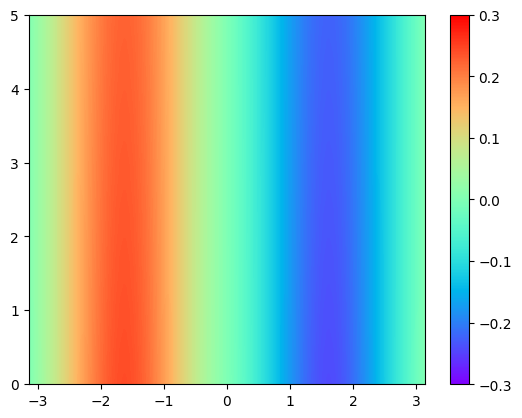

In [4]:
def test_for_solver():
  # Data generation
  kappa = 0.01
  period = 1
  T_lim = 5

  # define initial condition
  num_sine_terms = 3
  sine_amplitude = 0.2
  Nx = 500
  Nt = 500

  # training data
  num_of_sensor = 100
  key = jax.random.PRNGKey(2)
  keys = jax.random.split(key, 5)
  (x, t, s), (u, u0) = solve_burgers(keys[2], num_of_sensor, num_sine_terms, sine_amplitude, Nx, Nt, T_lim, period,
                                     kappa)
  XX, TT = np.meshgrid(x, t)
  plt.pcolor(XX, TT, s.T, shading="auto", cmap="rainbow")
  plt.clim([-0.3, 0.3])
  plt.colorbar()
  plt.show()


test_for_solver()

In [5]:
# generate training data correspondingto one input sample
def generate_one_training_data(key, num_of_sensors, num_query_points, num_sine_terms, sine_amplitude, Nx, Nt, T_lim,
                               period, kappa):
  # numerical solution
  (x, t, s), (u, u0) = solve_burgers(key, num_of_sensors, num_sine_terms, sine_amplitude, Nx, Nt, T_lim, period,
                                     kappa)  # u'shape: [num_of_sensors, ]
  # generate subkeys
  subkeys = jax.random.split(key, 2)
  # sample input data, copy u for num_query_points times
  u_train = np.tile(u, (num_query_points, 1))  # u_train'shape: [num_query_points, num_of_sensors]
  # sample query points, random select num_query_points points from Nx and Nt points
  x_query_idx = jax.random.choice(subkeys[0], np.arange(Nx), shape=(num_query_points, 1))
  x_query = x[x_query_idx]  # x_query'shape: [num_query_points, 1]
  t_query_idx = jax.random.choice(subkeys[1], np.arange(Nt), shape=(num_query_points, 1))
  t_query = t[t_query_idx]  # t_query'shape: [num_query_points, 1]
  y_train = np.hstack((x_query, t_query))  # y_train'shape: [num_query_points, 2]
  # outputs data
  s_train = s[x_query_idx, t_query_idx]  # s_train'shape: [num_query_points, 1]
  return u_train, y_train, s_train

In [6]:
def generate_one_test_data(key, num_of_sensors, num_query_points, num_sine_terms, sine_amplitude, Nx, Nt, T_lim, period,
                           kappa):
  (x, t, s), (u, u0) = solve_burgers(key, num_of_sensors, num_sine_terms, sine_amplitude, Nx, Nt, T_lim, period, kappa)
  XX, TT = np.meshgrid(x, t)
  u_test = np.tile(u, (Nx * Nt, 1))  # copy u for Nx * Nt times
  y_test = np.hstack((XX.flatten()[:, None], TT.flatten()[:, None]))  # flatten x, t
  s_test = s.T.flatten() # flatten默认逐行展开，这里需要先转至再展开，才能维持对应关系
  return u_test, y_test, s_test

In [7]:
# select N_train keys to create N_train functions
num_samples = 500 # for total batch, 500 is the maximum
num_of_sensors = 100
num_query_points = 100

key = jax.random.PRNGKey(2)
subkeys = jax.random.split(key, num_samples)
gen_train_data = partial(generate_one_training_data,
                         num_of_sensors=num_of_sensors,
                         num_query_points=num_query_points,
                         num_sine_terms=3,
                         sine_amplitude=0.2,
                         Nx=100,
                         Nt=100,
                         T_lim=5,
                         period=1,
                         kappa=0.01)
u_train, y_train, s_train = jax.vmap(gen_train_data)(subkeys)
print("training info: ", u_train.shape, y_train.shape, s_train.shape)

training info:  (500, 100, 100) (500, 100, 2) (500, 100, 1)


In [8]:
class DeepONet2D(eqx.Module):
  branch_net: eqx.nn.MLP
  trunk_net: eqx.nn.MLP
  bias: jax.Array

  def __init__(self, in_size, width_size, depth, out_size, activation, key):
    b_key, t_key = jax.random.split(key)
    self.branch_net = eqx.nn.MLP(in_size=in_size,
                                 out_size=out_size,
                                 width_size=width_size,
                                 depth=depth,
                                 activation=activation,
                                 key=b_key)
    self.trunk_net = eqx.nn.MLP(in_size=2,
                                out_size=out_size,
                                width_size=width_size,
                                depth=depth,
                                activation=activation,
                                key=t_key)
    self.bias = np.zeros((1,))  # G(u)(y) is a scaler

  def __call__(self, x_branch, x_trunk):
    """forward process

    Args:
        x_branch (jax.Array): branch inputs, shape: [num_query_points, num_of_sensors]
        x_trunk (jax.Array): trunk inputs, shape: [num_query_points, 2]
    """
    # [num_query_points, out_size]
    branch_out = jax.vmap(self.branch_net)(x_branch)  # apply the branch network to each query point
    # [num_query_points, out_size]
    trunk_out = jax.vmap(self.trunk_net)(x_trunk)  # apply the trunk network to each query point
    # [num_query_points,]
    inner_product = np.sum(branch_out * trunk_out, axis=1)  # compute the sum of b_k*t_k, k=1,...,num_query_points
    return inner_product + self.bias  # broadcast the bias to the shape of inner_product

In [10]:
operator = DeepONet2D(in_size=num_of_sensors,
                      width_size=50,
                      depth=4,
                      out_size=50,
                      activation=jax.nn.relu,
                      key=jax.random.PRNGKey(2))
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(operator, eqx.is_array))


def loss_fn(model, branch_input, trunk_input, s):
  pred = jax.vmap(model)(branch_input, trunk_input)
  pred = pred[:, :, np.newaxis]
  return np.mean((pred - s)**2)


@eqx.filter_jit
def update_fn(model, state):
  loss, grad = eqx.filter_value_and_grad(loss_fn)(model, u_train, y_train, s_train)
  updates, new_state = optimizer.update(grad, state, model)
  new_model = eqx.apply_updates(model, updates)
  return new_model, new_state, loss


train_loss = []
for i in tqdm(range(100_000)):
  operator, opt_state, loss = update_fn(operator, opt_state)
  train_loss.append(loss)

100%|██████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [28:40<00:00, 58.13it/s]


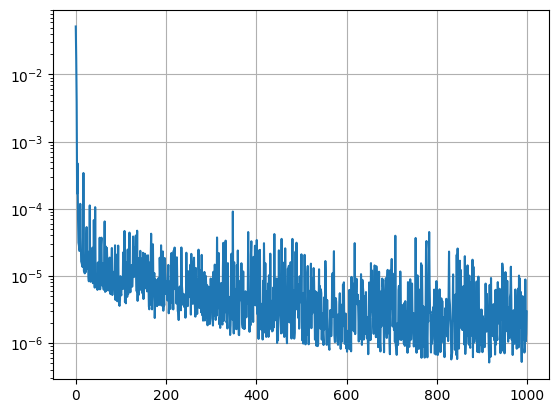

In [11]:
plt.semilogy(train_loss[::100])
plt.grid()

In [12]:
num_samples_test = 100
num_of_query_points_test = 100_00

test_key = jax.random.PRNGKey(3)
subkeys_test = jax.random.split(test_key, num_samples_test)
gen_test_data = partial(generate_one_test_data,
                        num_of_sensors=num_of_sensors,
                        num_query_points=num_of_query_points_test,
                        num_sine_terms=3,
                        sine_amplitude=0.2,
                        Nx=100,
                        Nt=100,
                        T_lim=5,
                        period=1,
                        kappa=0.01)
u_test, y_test, s_test = jax.vmap(gen_test_data)(subkeys_test)
print("test info: ", u_test.shape, y_test.shape, s_test.shape)

test info:  (100, 10000, 100) (100, 10000, 2) (100, 10000)


In [13]:
pred = jax.vmap(operator)(u_test, y_test)  # [num_samples_test, num_query_points_test]
print(pred.shape)

(100, 10000)


In [18]:
x = np.linspace(-1 * np.pi, 1 * np.pi, 100)
t = np.linspace(0, 5, 100)
XX, TT = np.meshgrid(x, t)

def restore(loc, value,XX,TT):
  _restore = griddata(loc, value.flatten(), (XX, TT), method="cubic")
  return _restore

L2 relative error: 0.4778%


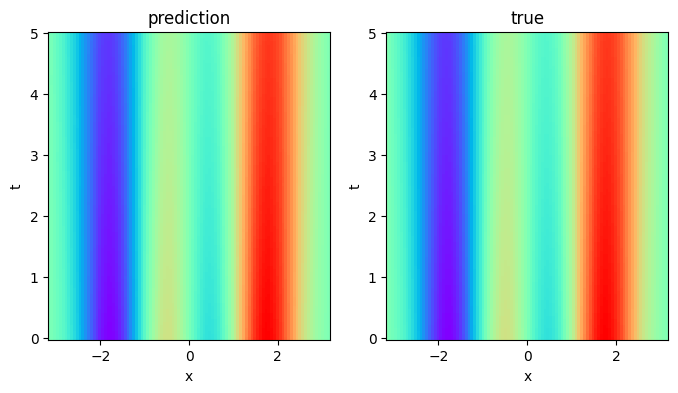

In [19]:
# check one test sample
_idx = 150
_pred = restore(y_test[_idx, :], pred[_idx, :], XX, TT)
_true = restore(y_test[_idx, :], s_test[_idx, :], XX, TT)

error = np.linalg.norm(_true - _pred, 2) / np.linalg.norm(_true, 2)
print(f"L2 relative error: {error * 100 :.4f}%")

fig,axs = plt.subplots(1,2,figsize=(8,4))
axs[0].pcolor(XX, TT, _pred, cmap="rainbow", shading="auto")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
axs[0].set_title("prediction")
axs[1].pcolor(XX, TT, _true, cmap="rainbow", shading="auto")
axs[1].set_title("true")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
plt.show()

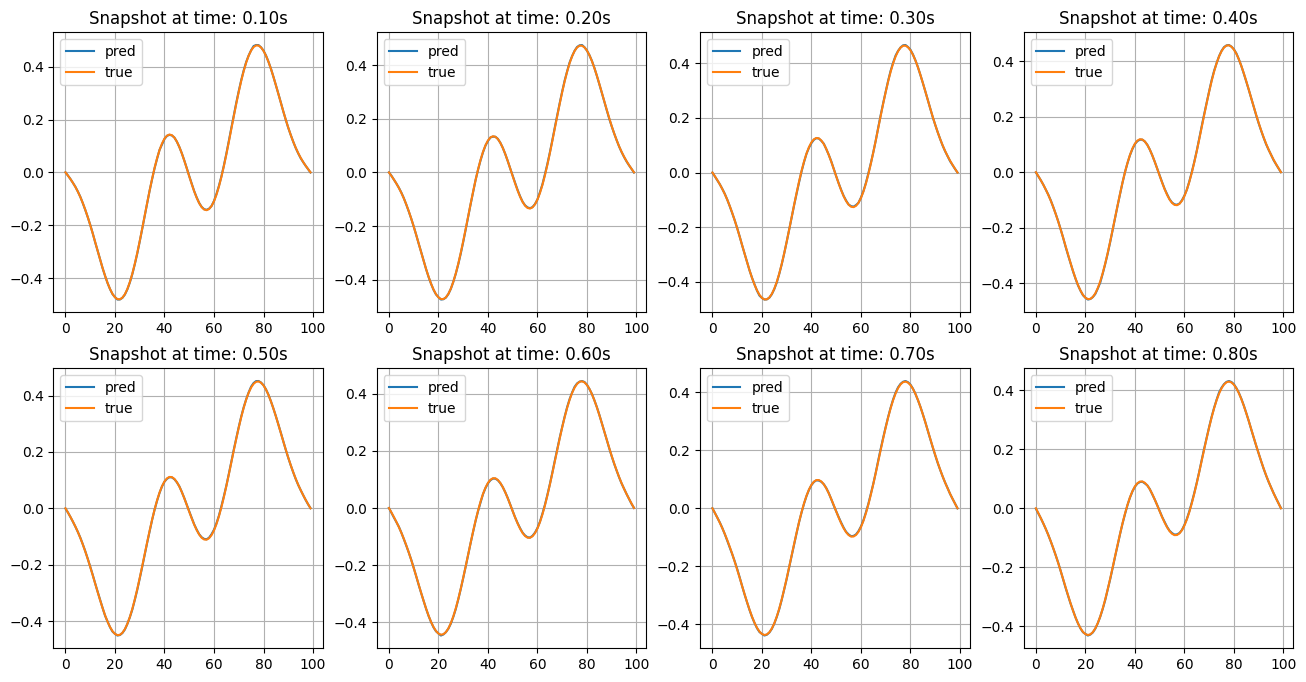

In [20]:
fig,axs = plt.subplots(2,4,figsize=(16,8))
times = np.array([1,2,3,4,5,6,7,8],dtype=np.int32)
for i in range(len(times)):
    axs[int(i/4),int(i%4)].plot(_pred[times[i]*10,:],label="pred")
    axs[int(i/4),int(i%4)].plot(_true[times[i]*10,:],label="true")
    axs[int(i/4),int(i%4)].legend()
    axs[int(i/4),int(i%4)].set_title(f"Snapshot at time: {times[i]*0.1 :.2f}s")
    axs[int(i/4),int(i%4)].grid()

In [35]:
# cal total L2 norm
def normalized_l2_error(pred,ref):
    diff_norm = np.linalg.norm(pred-ref)
    ref_norm = np.linalg.norm(ref)
    return diff_norm/ref_norm

test_error = []
for sample_idx in range(y_test.shape[0]):
    _pred = restore(y_test[sample_idx, :], pred[sample_idx, :], XX, TT)
    _true = restore(y_test[sample_idx, :], s_test[sample_idx, :], XX, TT)
    l2_norm = normalized_l2_error(_pred,_true)
    test_error.append(l2_norm)
mean_error = np.mean(np.array(test_error))
std_error = np.std(np.array(test_error))
print(f"Test L2 norm error of all 100 samples, with mean: {mean_error*100 :.4f}% and std: {std_error*100 :.4f}%")

Test L2 norm error of all 100 samples, with mean: 0.6261% and std: 0.1954%


In [34]:
# save model
eqx.tree_serialise_leaves("./weight/Burgers1d_DeepONet.eqx",operator)
# load model
# eqx.tree_deserialise_leaves("Burgers1d_DeepONet.eqx",operator)